In [284]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
from helpers import *
import csv

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the Data
Note that `ratings` is a sparse matrix that in the shape of (num_items, num_users)

In [285]:
path_dataset = "47b05e70-6076-44e8-96da-2530dc2187de_data_train.csv"
path_submission = "9b4d32bb-f99a-466f-95a1-0ab80048971c_sample_submission (2).csv"
ratings = load_data(path_dataset)
ratings_=ratings.toarray()#transform type from sparse matrix to np.array
test=load_data(path_submission)
submission = load_submission(path_submission)
submission_row_col = submission[0]
submission_pos = submission[1]

number of items: 10000, number of users: 1000
number of items: 10000, number of users: 1000


### Plot the number of ratings per movie and user

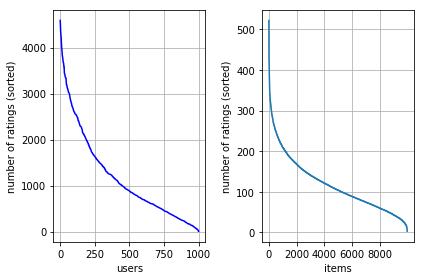

min # of items per user = 8, min # of users per item = 3.


In [286]:
from plots import *

num_items_per_user, num_users_per_item = plot_raw_data(ratings)
num_item, num_user = ratings.get_shape()

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

### Extract mean ratings for each user

In [287]:
def extract_user_mean(train,ratings):#maybe useful in prediction
    user_nnz = train.getnnz(axis=0)
    user_sum = train.sum(axis=0)
    user_mean = np.empty((1, num_user))
    for ind in range(num_user):
        user_mean[0,ind] = user_sum[0,ind] / user_nnz[ind]
        user_ind=ratings[:,ind]
        user_ind[user_ind==0]=user_mean[0,ind]
        ratings[:,ind]=user_ind
    return ratings

### Distance matrix

def build_distance_matrix(train, u):
    distance_list = []
    _, K= u.shape
    for k in range(K):
        sum_squares = np.sum(np.square(train.T - u[:, k]), axis=1)
        distance_list.append(sum_squares)
    return np.array(distance_list).T

### Initialization

In [288]:
def initialize_u(train,K):
    u_initial = (train.T[np.random.choice(num_user, K)]).T
    return u_initial


### Update z and u

In [289]:
def update_z(u,K,train):
    #nz_train, nz_item_userindices, nz_user_itemindices = build_index_groups(train)
    z = np.zeros((K,num_user))
    loss = []
    for n in range(num_user):#here
        inv = np.empty((1,K))
        valid_items = np.where(train[:,n]>0)
        for k in range(K):
            inv[0,k] = np.mean(np.square(train[valid_items,n]-u[valid_items,k]))# this decide how we deal with zeros
        znk=np.nanargmin(inv,axis=1)
        loss.append(np.nanmin(inv)) 
        
        z[znk,n]=1
    return z,loss

def update_u(z,K,train):
    u = np.zeros((num_item,K))
    for k in range(K):
        sum=np.zeros((num_item,1))
        for n in range(num_user):
            sum=sum+z[k,n]*train[:,n]
        u[:,k]=sum[1]/np.sum((z[k,:]))
    return u



def update_kmeans_uz_parameters(train, u_old):
    D,_= train.shape
    _,K = u_old.shape
    z = np.zeros((K,num_user))
    distance_matrix = build_distance_matrix(train, u_old)
    losses = np.min(distance_matrix, axis=1)
    assignments = np.argmin(distance_matrix, axis=1)
    # update the u
    u = np.empty((num_item, K))
    for k in range(K):
        users = np.where(assignments == k)
        u[:,k] = np.mean(np.squeeze(train.T[users,:]), axis=0)
    return losses, assignments, np.nan_to_num(u)

In [ ]:
def kmeans_demo(ratings,ratings_):
    # init some empty lists to store the result.
    loss_list = []
    max_iters = 10
# K_range = [4,6,8,10,14,12,14,16,18,20,22,24]
    K=4
    threshold=1e-5
   # x_predict = np.zeros((num_item,num_user))
   # train= extract_user_mean(ratings,ratings2)
  #  for K in set(K_range):
    # initialize the cluster.
    u_old = initialize_u(ratings, K)
    u_old = u_old.toarray()
    
    # start the kmeans algorithm.
    for i in range(max_iters):
        # update z and mu
        z,loss = update_z(u_old,K,ratings_)
        u = update_u(z,K,ratings_)
        # calculate the average loss over all points
        average_loss = np.mean(loss)
        loss_list.append(average_loss)
        print("The current iteration of k-means is: {m}, the average loss is {l}.".format(m=i, l=average_loss))
        # check converge
        if i > 0 and np.abs(loss_list[-1] - loss_list[-2]) < threshold:
            break
        # output plot
       # print(len(u),u_old.shape[0])
        #plot_kmeans(train, u, u_old, output_figure + "kmean_iter{m}".format(m=i))
        # update k-means information.
        u_old = u
   # x_predict=x_predict+u.dot(z)
   # x_final=x_predict/len(K_range)
    return z,u

z,u = kmeans_demo(ratings,ratings_) 

In [ ]:
nz_train, nz_item_userindices, nz_user_itemindices = build_index_groups(test)

In [ ]:
predictions=[]
i=0
for user, items in nz_user_itemindices:
    K = (np.where(z[:,user]==1))[0]
    group_users = (np.where (z[K,:]==1))[1]
    for item in items:
        group_ratings=ratings_[item, group_users]  
        group_valid_ratings = (group_ratings[np.where(group_ratings>0)]).astype(int)
        counts=np.bincount(group_valid_ratings)
        max_=max(counts)
        value_pred=np.mean(np.where(counts==max_))
        if value_pred < 1:
            value_pred = 1
        elif value_pred > 5:
            value_pred = 5
        else:
            value_pred = round(value_pred)
        predictions.append(value_pred) 


In [ ]:
create_csv_submission(submission_pos,predictions, "kmeans.csv")